## Run the cells to generate charts for visualizing the benchmarks


### Original LayerSkip Visualizations

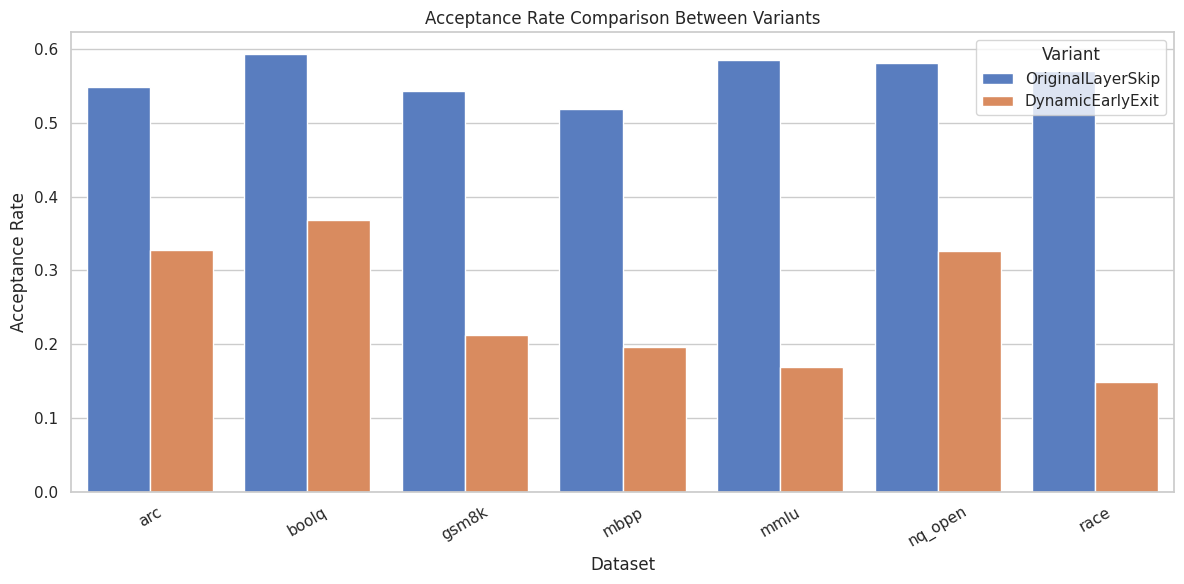

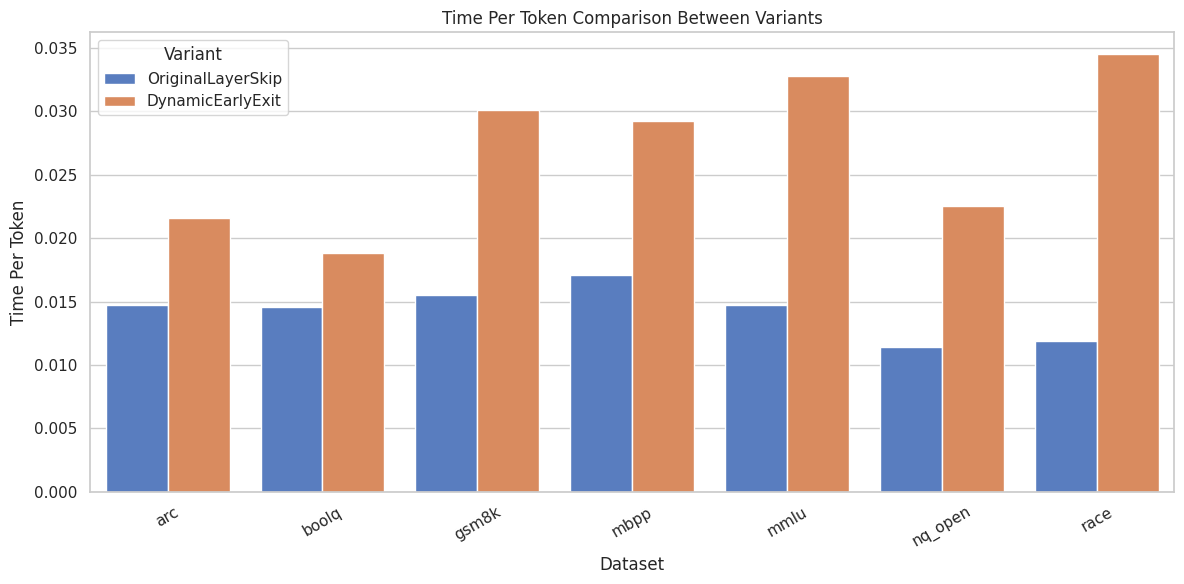

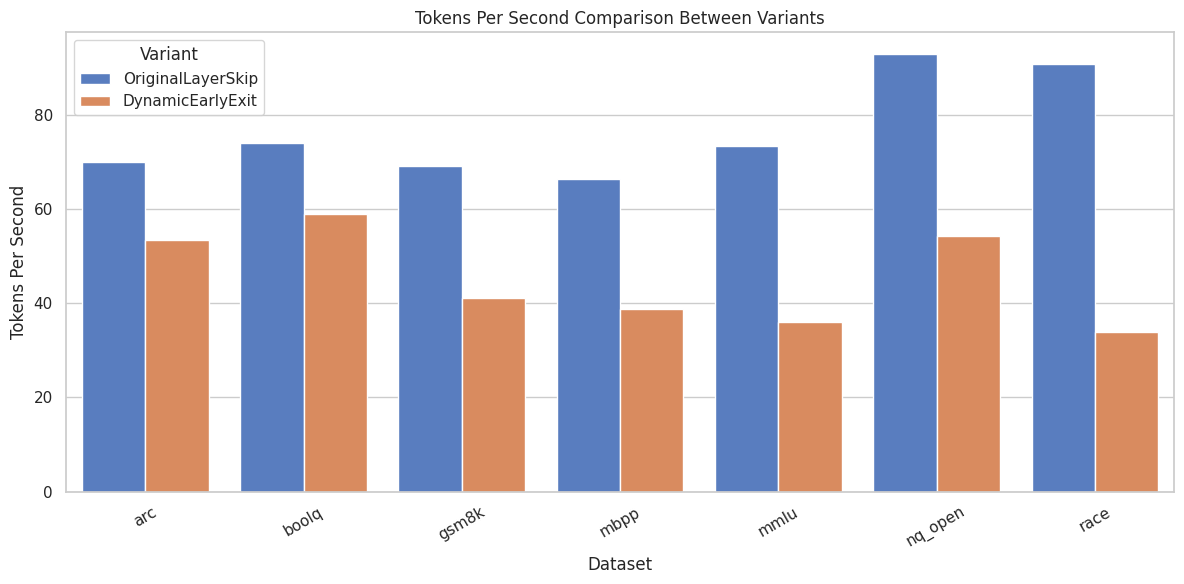

In [21]:
import glob
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

metrics_to_plot = ["acceptance_rate", "time_per_token", "tokens_per_second"]

# Step 2: Function to load JSON files
def load_benchmarks(path_pattern, label):
    files = glob.glob(path_pattern)
    results = []
    
    for file_path in sorted(files):
        with open(file_path, 'r') as f:
            content = f.read()
        
        json_objects = re.findall(r'\{.*?\}(?=\{|\Z)', content, flags=re.DOTALL)
        parsed_data = [json.loads(obj) for obj in json_objects]
        
        metrics = parsed_data[-1]

        filename = file_path.split('/')[-1].replace('.json', '')
        dataset = re.sub(r'benchmark_(.*?)_(original|dynamicearlyexit)', r'\1', filename)

        result = {
            "dataset": dataset,
            "variant": label,
            "acceptance_rate": metrics["acceptance_rate"]["mean"],
            "time_per_token": metrics["time_per_token"]["mean"],
            "tokens_per_second": metrics["tokens_per_second"]["mean"],
        }
        results.append(result)
    
    return results

original_results = load_benchmarks('OriginalLayerSkip/*.json', label='OriginalLayerSkip')
dynamic_results = load_benchmarks('DynamicEarlyExit/*.json', label='DynamicEarlyExit')

df = pd.DataFrame(original_results + dynamic_results)

sns.set_theme(style="whitegrid")

for metric in metrics_to_plot:
    plt.figure(figsize=(12, 6))

    order = sorted(df['dataset'].unique())

    sns.barplot(
        data=df, 
        x="dataset", 
        y=metric, 
        hue="variant", 
        order=order, 
        palette="muted"
    )

    plt.title(f'{metric.replace("_", " ").title()} Comparison Between Variants')
    plt.ylabel(metric.replace("_", " ").title())
    plt.xlabel('Dataset')
    plt.xticks(rotation=30)

    plt.legend(title="Variant")
    plt.tight_layout()
    plt.show()
